In [100]:
# Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

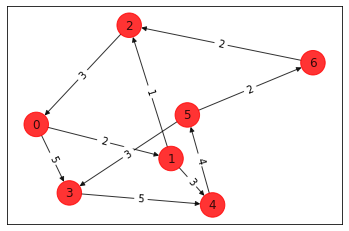

In [101]:
# Formation of Graph given the Patient-Donor pairs (nodes) and their Compatible pairs
G = nx.DiGraph(directed=True)

w = [2,3,5,1,3,3,5,2,4,2] # Add costs of Kidneys
G.add_weighted_edges_from([(0,1,w[0]), (2,0,w[1]), (0,3,w[2]), (1,2,w[3]), (1,4,w[4]), (5,3,w[5]), (3,4,w[6]), (6,2,w[7]), (4,5,w[8]), (5,6,w[9])])
# list is (i,j,weight) where (i,j) is the edge

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [104]:
# Gives the Value of the Cost Function when bitstring is input
def cost_fn(bit,dist_mat):
    solution=np.array([int(i) for i in bit])
    solution=np.array([0,1,1,0])
    sol =solution.reshape(2,2)
    cost=0
    A=100
    for i in range(np.shape(sol)[0]):
        x=0
        for j in range(np.shape(sol)[0]):
            x+=sol[i,j]
        cost+=A*(1-x)**2
    for i in range(np.shape(sol)[0]):
        x=0
        for j in range(np.shape(sol)[0]):
            x+=sol[j,i]
        cost+=A*(1-x)**2
    print(cost)       
    cost+= sum(sum(sol[:,:]*dist_mat))        
    return cost

In [105]:
# Computes Expectation Value
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = tsp(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [ ]:
# Multi-Angle QAOA Function which returns counts
def multi_angle_qaoa(G, theta) :
    
    # Multi-Angle QAOA circuit for TSP Problem
    def create_maqaoa_circ(G, theta):  
        nqubits = len(G.edges())
        
        # Distribution of Input Parameters
        qc = QuantumCircuit(nqubits)
        clauses = len(G.edges())
        nlayers = len(theta)//((nqubits*2)+clauses)
        beta = np.reshape(theta[:nlayers*nqubits], (nlayers,nqubits))
        gamma = np.reshape(theta[nlayers*nqubits:], (nlayers,nqubits+clauses))
    
        # Formation of Quantum Circuit simulating the Problem Hamiltonian
        for i in range(nqubits):
            qc.h(i)
    
        for irep in range(nlayers):
            k=0
            
            # problem unitary
            for i in range(nqubits):
                qc.rz(2 * gamma[irep,k], i)
                k+=1
            
            ###################################################
            # This Part is Remaining as we didn't get enough time to form a fn which applies a part of Problem Hamiltonian
            for pair in list(G.edges()):
                qc.rzz(2 * gamma[irep,k], pair[0], pair[1])
                k+=1
            qc.barrier()
            ###################################################
            
            # mixer unitary
            for i in range(nqubits):
                qc.rx(2 * beta[irep,i], i)
            qc.barrier()
        
        qc.measure_all()
        return qc
    
    def get_expectation_MAQAOA(G, shots=512):
        backend = Aer.get_backend('qasm_simulator')
        backend.shots = shots
    
        def execute_circ(theta):
        
            qc = create_maqaoa_circ(G, theta)
            counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
            return compute_expectation(counts, G)
    
        return execute_circ
    
    # Optimizing Parameters for Basic QAOA
    expectation = get_expectation_MAQAOA(G)
    global res_multi
    res_multi = minimize(expectation, theta, method='COBYLA')

    
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512

    qc_res = create_maqaoa_circ(G, res_multi.x)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    return counts

In [ ]:
# Input random Parameters that will be optimized
beta = np.array([[3,4,4,5,3,6,4,6,2,3]]) # Number of Parameters here = number of edges
gamma = np.array([[4,3,5,5,5,4,4,3,5]]) # Number of Parameters depends 
theta = np.concatenate((beta.flatten(), gamma.flatten()))

In [83]:
# Returns the Distribution and Solution

counts_multi = multi_angle_qaoa(G, theta_multi)
print("Multi-Angle QAOA : ", res_multi.fun)
plot_histogram(counts_multi, figsize = (10,10))

Traceback (most recent call last):
  Input In [83] in <cell line: 1>
    counts_multi = multi_angle_qaoa(G, theta_multi)
NameError: name 'multi_angle_qaoa' is not defined

Use %tb to get the full traceback.
